In [1]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Local application imports
from smile.population import Population, PopulationList
from smile.sampling import *
from smile.regression import RegressionResultList
from smile import helper
from smile.helper import truncatednormal
from smile.global_params import *

In [3]:
# Settings
seed = 3 # chosen by fair dice roll. guaranteed to be random. https://xkcd.com/221/
np.random.seed(seed)
np.set_printoptions(edgeitems=30, linewidth=100000)

## Experiment: Realistic Methodology

Purpose:  
   * Sampling similarly to what a real clinician would want

### Populations

In [4]:
# Simulation definition

def get_poster_populations(slope_option, error_option, npersons=100, npops=100):
    '''
    returns a PopulationList similar to the one described in the poster
    slope_option is 1, 2, or 3
    error_option is 30/100 or 50/100
    '''
    
    # Define and set visual score function
    pop = Population(npersons, f'poster with {slope_option} and {error_option}')
    gen_visualscores = lambda t,r,v0: np.maximum(-r*t+v0, VMIN)
    pop.set_score_generator('visual', gen_visualscores)
    gen_r = lambda shape: 0.2
    gen_v0 = lambda shape: np.random.randint(14, 18+1, shape)
    pop.set_parameter_generator('r', gen_r, 'population')
    pop.set_parameter_generator('v0', gen_v0, 'person')

    # Define and set symptom score function
    gen_symptomscores = lambda v,a,s0: np.maximum(a*v+s0, SMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_a = lambda shape: slope_option
    gen_s0 = lambda shape: np.random.normal(6, 2, shape)
    pop.set_parameter_generator('a', gen_a, 'population')
    pop.set_parameter_generator('s0', gen_s0, 'person')

    # Define and set error functions
    #Multiplicative
    pop.set_score_generator('symptom', lambda s,C: s*C)
    gen_C_mul = lambda shape: np.random.uniform(1-error_option, 1+error_option, shape)
    pop.set_parameter_generator('C', gen_C_mul, 'day')

    # Repeat
    pops = PopulationList.full(npops, pop)
    
    # Return
    return pops

npersons=10
npops=10
slope_options = (1, 2, 3)
error_options = (0.3, 0.5)

npersons=10
npops=10

poplists = np.empty((len(slope_options), len(error_options)), dtype=object)
for i, j in np.ndindex(poplists.shape):
    poplists[i, j] = get_poster_populations(slope_options[i], error_options[j], npersons, npops)
    poplists[i, j].generate()

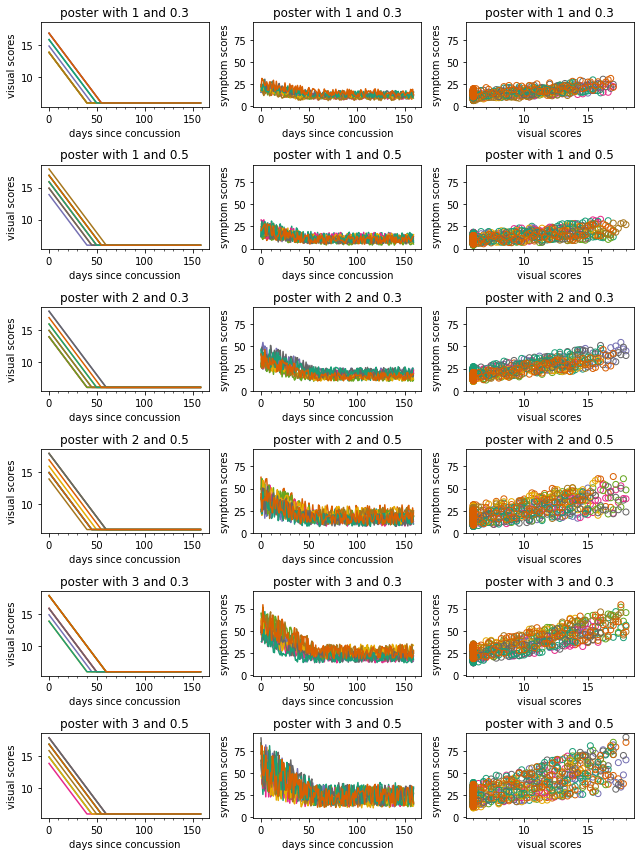

In [5]:
ncols = 3
nrows = poplists.size
scale = 2

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*scale*1.5, nrows*scale), squeeze=False, sharex='col', sharey='col')
npersons=None
ndays=None

for row in range(nrows):
    poplists.flatten()[row][0].plot(axes[row, 0], x='day', y='visual', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    poplists.flatten()[row][0].plot(axes[row, 1], x='day', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    poplists.flatten()[row][0].plot(axes[row, 2], x='visual', y='symptom', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    
    for ax in axes[row]: 
        ax.tick_params(labelbottom=True)

plt.tight_layout()
plt.show()

In [6]:
li = [[poplist.summarize()] for poplist in poplists.flat]
helper.print_collocated(li)

Title: 'list of poster with 1 and 0.3'   
Titles: [... 'poster with 1 and 0.3' ...]
N Persons: 100 / 100 = 1.00              
N Days: [... 160 ...]                    

Title: 'list of poster with 1 and 0.5'   
Titles: [... 'poster with 1 and 0.5' ...]
N Persons: 100 / 100 = 1.00              
N Days: [... 160 ...]                    

Title: 'list of poster with 2 and 0.3'   
Titles: [... 'poster with 2 and 0.3' ...]
N Persons: 100 / 100 = 1.00              
N Days: [... 160 ...]                    

Title: 'list of poster with 2 and 0.5'   
Titles: [... 'poster with 2 and 0.5' ...]
N Persons: 100 / 100 = 1.00              
N Days: [... 160 ...]                    

Title: 'list of poster with 3 and 0.3'   
Titles: [... 'poster with 3 and 0.3' ...]
N Persons: 100 / 100 = 1.00              
N Days: [... 160 ...]                    

Title: 'list of poster with 3 and 0.5'   
Titles: [... 'poster with 3 and 0.5' ...]
N Persons: 100 / 100 = 1.00              
N Days: [... 160 ...]        

### Filtering

In [7]:
filtered_poplists = np.empty_like(poplists)
for i, j in np.ndindex(poplists.shape):
    filtered_poplists[i, j] = poplists[i, j].filter('ratio_early', index_day=0, recovered_ratio=0.7, scorename='symptom', copy=True)

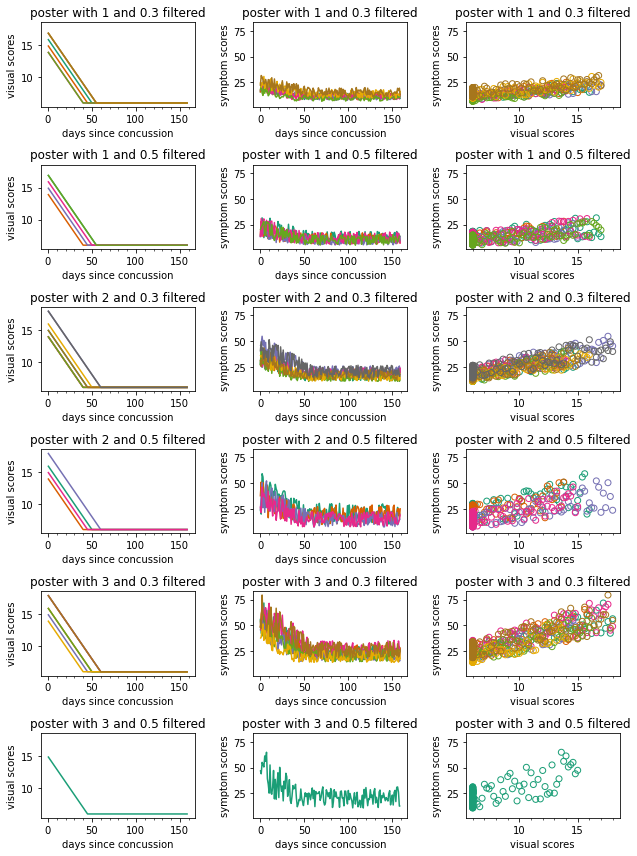

In [8]:
ncols = 3
nrows = filtered_poplists.size
scale = 2

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*scale*1.5, nrows*scale), squeeze=False, sharex='col', sharey='col')
npersons=None
ndays=None

for row in range(nrows):
    filtered_poplists.flatten()[row][0].plot(axes[row, 0], x='day', y='visual', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    filtered_poplists.flatten()[row][0].plot(axes[row, 1], x='day', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    filtered_poplists.flatten()[row][0].plot(axes[row, 2], x='visual', y='symptom', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    
    for ax in axes[row]: 
        ax.tick_params(labelbottom=True)
    
plt.tight_layout()
plt.show()

In [9]:
li = [[poplist.summarize()] for poplist in filtered_poplists.flat]
helper.print_collocated(li)

Title: 'list of poster with 1 and 0.3 filtered'   
Titles: [... 'poster with 1 and 0.3 filtered' ...]
N Persons: 65 / 100 = 0.65                        
N Days: [... 160 ...]                             

Title: 'list of poster with 1 and 0.5 filtered'   
Titles: [... 'poster with 1 and 0.5 filtered' ...]
N Persons: 40 / 100 = 0.40                        
N Days: [... 160 ...]                             

Title: 'list of poster with 2 and 0.3 filtered'   
Titles: [... 'poster with 2 and 0.3 filtered' ...]
N Persons: 60 / 100 = 0.60                        
N Days: [... 160 ...]                             

Title: 'list of poster with 2 and 0.5 filtered'   
Titles: [... 'poster with 2 and 0.5 filtered' ...]
N Persons: 42 / 100 = 0.42                        
N Days: [... 160 ...]                             

Title: 'list of poster with 3 and 0.3 filtered'   
Titles: [... 'poster with 3 and 0.3 filtered' ...]
N Persons: 55 / 100 = 0.55                        
N Days: [... 160 ...]      

### Sampling

In [10]:
def get_traditional_methodology():
    methodology = Methodology('traditonal')
    
    first_delay_func = lambda shape: helper.beta(shape, 7, 28, 14, 2.9).astype('int') #90% at 21
    
    methodology.add_sampler(TraditionalSampler(day=0, delay=first_delay_func))
    methodology.add_sampler(TraditionalSampler(day=('sample', 0), delay=14))
    methodology.add_sampler(TraditionalSampler(day=('sample', 0), delay=28))
    
    return methodology
    
def get_realistic_methodology():
    methodology = Methodology('realistic')

    #limit is irrelevant because max(day+delay) < NDAYS
    #if_reached is irrelevant because first sampling method
    first_delay_func = lambda shape: helper.beta(shape, 7, 28, 14, 2.9).astype('int') #90% at 21
    methodology.add_sampler(TraditionalSampler(day=0, delay=first_delay_func))

    #if_reached is irrelevant because index is previous sample
    other_delay_func = lambda shape: helper.beta(shape, 0, 14, 4, 3.8).astype('int') #90% at 7
    methodology.add_sampler(SmileSampler(index=('sample', -1), ratio=0.5, triggered_by_equal=True, scorename='symptom',
                                         delay=other_delay_func, limit=((-1, lambda prev_day: prev_day+28), 'clip'), if_reached='NaN'))

    #same delay as previous
    methodology.add_sampler(MagnitudeSampler(value=6, triggered_by_equal=False, scorename='symptom',
                                             delay=other_delay_func, limit=(LASTVISIT, 'clip'), if_reached='NaN'))
    
    return methodology

In [11]:
# Sampling

methodologies = [get_traditional_methodology(), get_realistic_methodology()]

sampled_poplists = np.empty((*poplists.shape, len(methodologies)), dtype=object)
for i, j in np.ndindex(poplists.shape):
    sampled_poplists[i, j, 0] = methodologies[0].sample(filtered_poplists[i, j])
    sampled_poplists[i, j, 1] = methodologies[1].sample(filtered_poplists[i, j])

:: UserWarning: There is at least one person who didn't reach his milestone


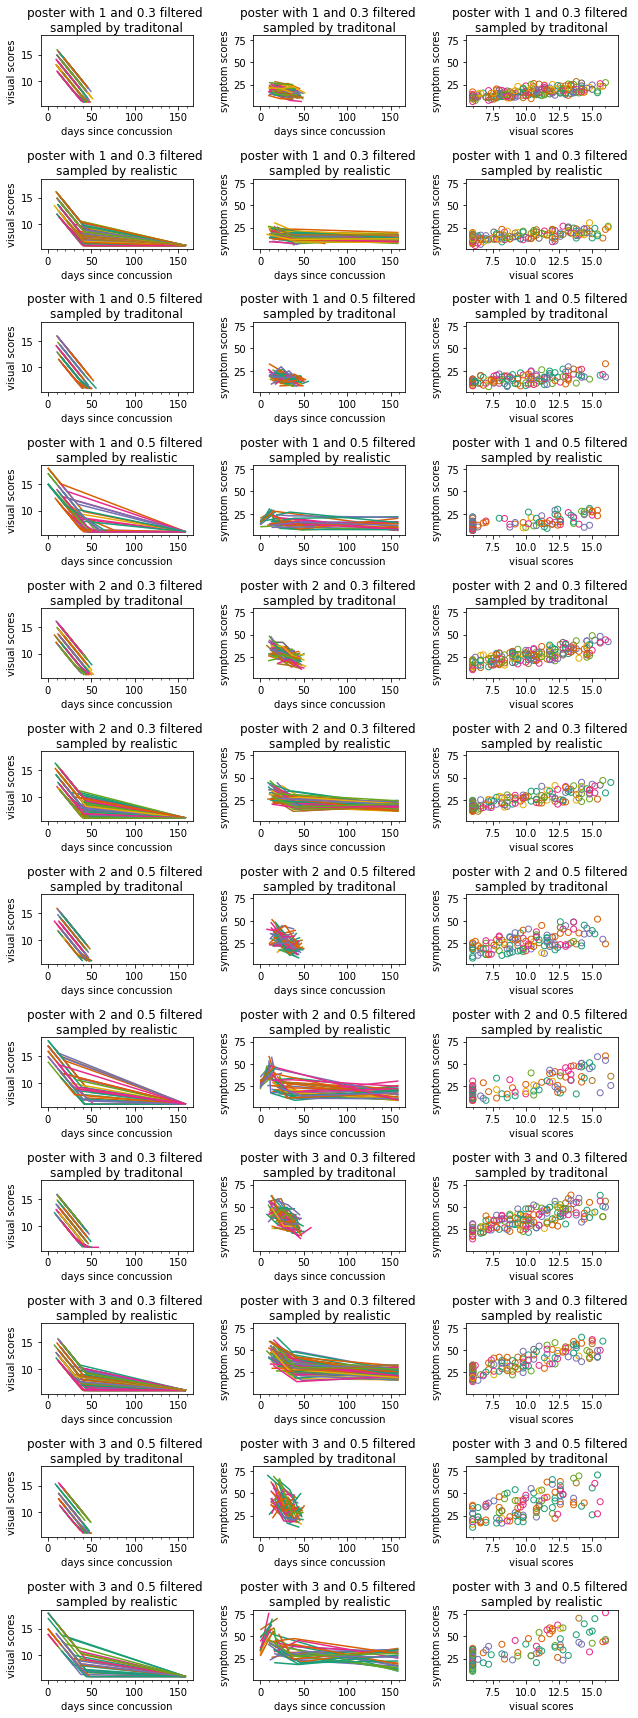

In [12]:
ncols = 3
nrows = sampled_poplists.size
scale = 2

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*scale*1.5, nrows*scale), squeeze=False, sharex='col', sharey='col')
npersons=None
ndays=None

for row in range(nrows):
    sampled_poplists.flat[row].plot(axes[row, 0], x='day', y='visual', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    sampled_poplists.flat[row].plot(axes[row, 1], x='day', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    sampled_poplists.flat[row].plot(axes[row, 2], x='visual', y='symptom', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    
    for ax in axes[row]: 
        ax.tick_params(labelbottom=True)
    
plt.tight_layout()
plt.show()

In [13]:
li = [[poplist.summarize()] for poplist in sampled_poplists.flat]
helper.print_collocated(li)

Title: 'poster with 1 and 0.3 filtered \nsampled by traditonal'                                                               
Titles: [... 'poster with 1 and 0.3 filtered \nsampled by traditonal' ...]                                                    
N Persons: 65 / 100 = 0.65                                                                                                    
N Samplers: [... 3 ...] / [... 160 ...]                                                                                       
Reached limits: [... (0, 0, 0) ...] -- [... ('raise', 'raise', 'raise') ...]                                                  
Already reached: [... (0, 0, 0) ...] -- [... ('raise', 'raise', 'raise') ...]                                                 

Title: 'poster with 1 and 0.3 filtered \nsampled by realistic'                                                                
Titles: [... 'poster with 1 and 0.3 filtered \nsampled by realistic' ...]                                     

## Experiment: Realistic Methodology With different simulation

### Populations

In [14]:
# Simulation definition

def get_worddoc_populations(slope_option, error_option, npersons=100, npops=100):
    
    # Define and set visual score function
    pop = Population(npersons, title=f'realistic with {slope_option} and {error_option}')
    gen_visualscores = lambda t,r,v0: np.maximum(-r*t+v0, VMIN)
    pop.set_score_generator('visual', gen_visualscores)
    gen_r = lambda shape: helper.beta(shape, 0, 2, 0.2, 1.4) #median at 0.4
    gen_v0 = lambda shape: helper.truncatednormal_general(14, 16, 18, 1, shape)
    pop.set_parameter_generator('r', gen_r, 'person')
    pop.set_parameter_generator('v0', gen_v0, 'person')
    
    #Define and set symptom score functions
    gen_symptomscores = lambda v,a: a*(v-VMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_a = lambda shape: slope_option
    pop.set_parameter_generator('a', gen_a, 'population')
    
    # Define and set error functions
    #Multiplicative
    pop.set_score_generator('symptom', lambda s,C: s*C)
    gen_C_mul = lambda shape: np.random.uniform(1-error_option, 1+error_option, shape)
    pop.set_parameter_generator('C', gen_C_mul, 'day')

    # Repeat
    pops = PopulationList.full(npops, pop)
    
    # Return
    return pops
    
npersons=10
npops=10
slope_options = (1, 2, 3)
error_options = (0.3, 0.5)

npersons=10
npops=10

poplists = np.empty((len(slope_options), len(error_options)), dtype=object)
for i, j in np.ndindex(poplists.shape):
    poplists[i, j] = get_worddoc_populations(slope_options[i], error_options[j], npersons, npops)
    poplists[i, j].generate()

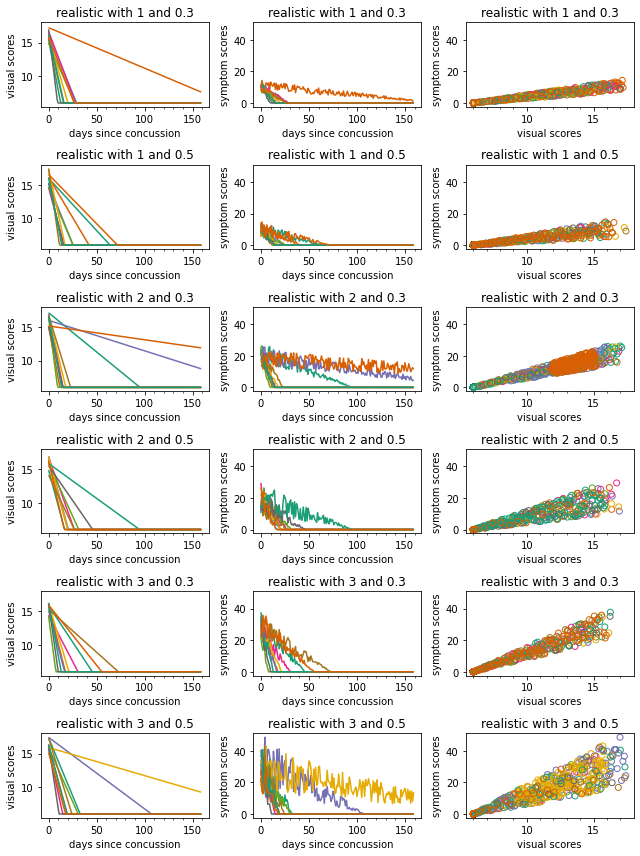

In [15]:
ncols = 3
nrows = poplists.size
scale = 2

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*scale*1.5, nrows*scale), squeeze=False, sharex='col', sharey='col')
npersons=None
ndays=None

for row in range(nrows):
    poplists.flatten()[row][0].plot(axes[row, 0], x='day', y='visual', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    poplists.flatten()[row][0].plot(axes[row, 1], x='day', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    poplists.flatten()[row][0].plot(axes[row, 2], x='visual', y='symptom', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    
    for ax in axes[row]: 
        ax.tick_params(labelbottom=True)
    
plt.tight_layout()
plt.show()

In [16]:
li = [[poplist.summarize()] for poplist in poplists.flat]
helper.print_collocated(li)

Title: 'list of realistic with 1 and 0.3'   
Titles: [... 'realistic with 1 and 0.3' ...]
N Persons: 100 / 100 = 1.00                 
N Days: [... 160 ...]                       

Title: 'list of realistic with 1 and 0.5'   
Titles: [... 'realistic with 1 and 0.5' ...]
N Persons: 100 / 100 = 1.00                 
N Days: [... 160 ...]                       

Title: 'list of realistic with 2 and 0.3'   
Titles: [... 'realistic with 2 and 0.3' ...]
N Persons: 100 / 100 = 1.00                 
N Days: [... 160 ...]                       

Title: 'list of realistic with 2 and 0.5'   
Titles: [... 'realistic with 2 and 0.5' ...]
N Persons: 100 / 100 = 1.00                 
N Days: [... 160 ...]                       

Title: 'list of realistic with 3 and 0.3'   
Titles: [... 'realistic with 3 and 0.3' ...]
N Persons: 100 / 100 = 1.00                 
N Days: [... 160 ...]                       

Title: 'list of realistic with 3 and 0.5'   
Titles: [... 'realistic with 3 and 0.5' ...]
N Per

### Filtering

In [17]:
filtered_poplists = np.empty_like(poplists)
for i, j in np.ndindex(poplists.shape):
    filtered_poplists[i, j] = poplists[i, j].filter('ratio_early', index_day=0, recovered_ratio=0.7, scorename='symptom', copy=True)

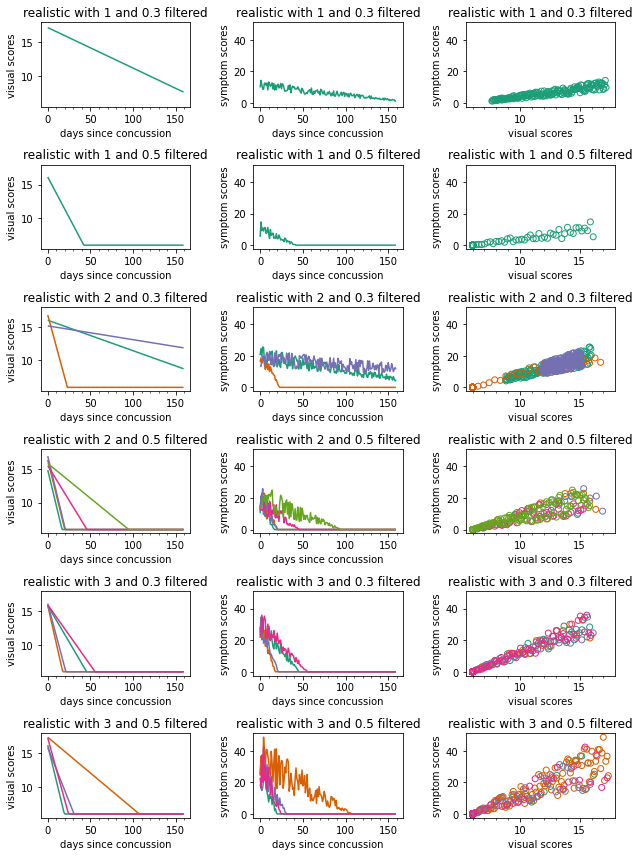

In [18]:
ncols = 3
nrows = filtered_poplists.size
scale = 2

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*scale*1.5, nrows*scale), squeeze=False, sharex='col', sharey='col')
npersons=None
ndays=None

for row in range(nrows):
    filtered_poplists.flatten()[row][0].plot(axes[row, 0], x='day', y='visual', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    filtered_poplists.flatten()[row][0].plot(axes[row, 1], x='day', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    filtered_poplists.flatten()[row][0].plot(axes[row, 2], x='visual', y='symptom', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    
    for ax in axes[row]: 
        ax.tick_params(labelbottom=True)
    
plt.tight_layout()
plt.show()

In [19]:
li = [[poplist.summarize()] for poplist in filtered_poplists.flat]
helper.print_collocated(li)

Title: 'list of realistic with 1 and 0.3 filtered'   
Titles: [... 'realistic with 1 and 0.3 filtered' ...]
N Persons: 31 / 100 = 0.31                           
N Days: [... 160 ...]                                

Title: 'list of realistic with 1 and 0.5 filtered'   
Titles: [... 'realistic with 1 and 0.5 filtered' ...]
N Persons: 17 / 100 = 0.17                           
N Days: [... 160 ...]                                

Title: 'list of realistic with 2 and 0.3 filtered'   
Titles: [... 'realistic with 2 and 0.3 filtered' ...]
N Persons: 33 / 100 = 0.33                           
N Days: [... 160 ...]                                

Title: 'list of realistic with 2 and 0.5 filtered'   
Titles: [... 'realistic with 2 and 0.5 filtered' ...]
N Persons: 33 / 100 = 0.33                           
N Days: [... 160 ...]                                

Title: 'list of realistic with 3 and 0.3 filtered'   
Titles: [... 'realistic with 3 and 0.3 filtered' ...]
N Persons: 34 / 100 = 0.

### Sampling

In [20]:
# Sampling

methodologies = [get_traditional_methodology(), get_realistic_methodology()]

sampled_poplists = np.empty((*poplists.shape, len(methodologies)), dtype=object)
for i, j in np.ndindex(poplists.shape):
    sampled_poplists[i, j, 0] = methodologies[0].sample(filtered_poplists[i, j])
    sampled_poplists[i, j, 1] = methodologies[1].sample(filtered_poplists[i, j])

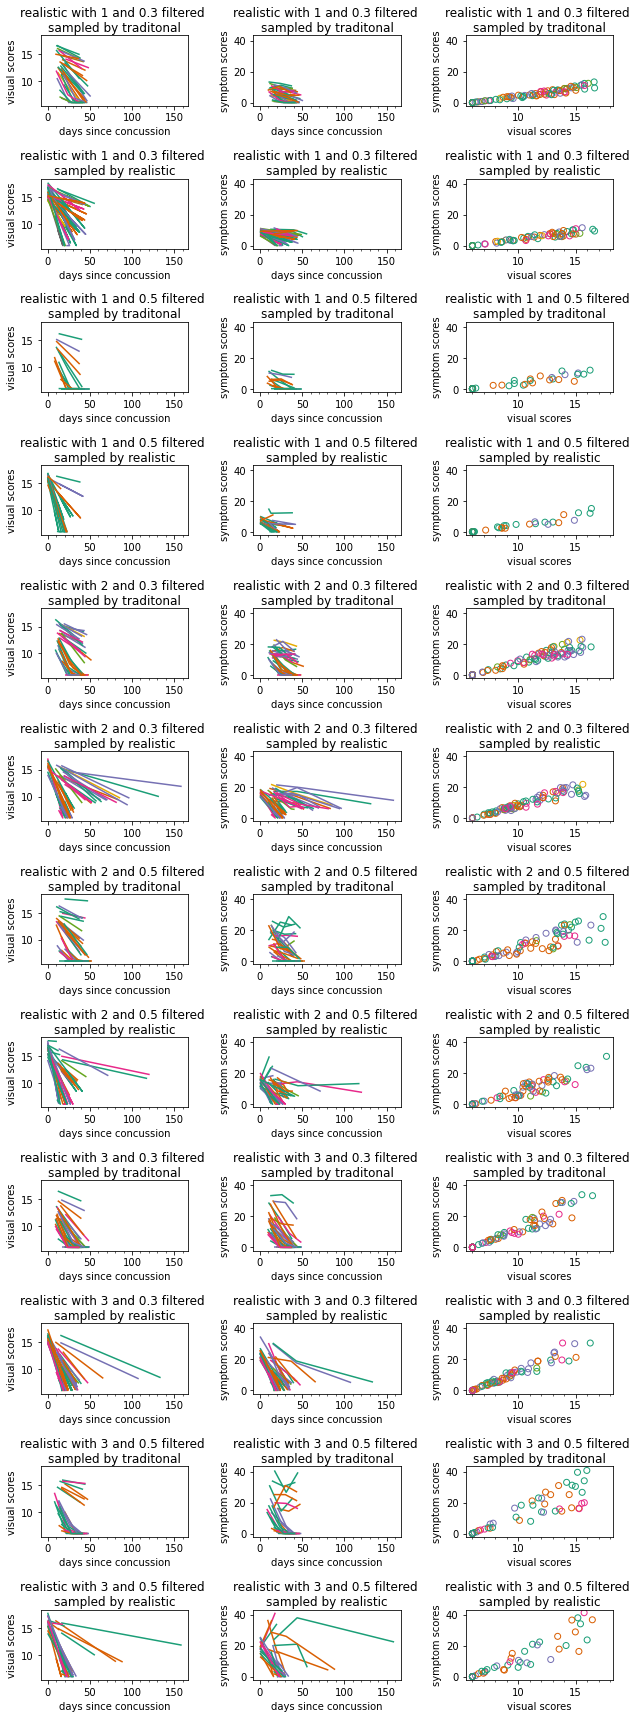

In [21]:
ncols = 3
nrows = sampled_poplists.size
scale = 2

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*scale*1.5, nrows*scale), squeeze=False, sharex='col', sharey='col')
npersons=None
ndays=None

for row in range(nrows):
    sampled_poplists.flat[row].plot(axes[row, 0], x='day', y='visual', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    sampled_poplists.flat[row].plot(axes[row, 1], x='day', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    sampled_poplists.flat[row].plot(axes[row, 2], x='visual', y='symptom', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    
    for ax in axes[row]: 
        ax.tick_params(labelbottom=True)
    
plt.tight_layout()
plt.show()

In [22]:
li = [[poplist.summarize()] for poplist in filtered_poplists.flat]
helper.print_collocated(li)

Title: 'list of realistic with 1 and 0.3 filtered'   
Titles: [... 'realistic with 1 and 0.3 filtered' ...]
N Persons: 31 / 100 = 0.31                           
N Days: [... 160 ...]                                

Title: 'list of realistic with 1 and 0.5 filtered'   
Titles: [... 'realistic with 1 and 0.5 filtered' ...]
N Persons: 17 / 100 = 0.17                           
N Days: [... 160 ...]                                

Title: 'list of realistic with 2 and 0.3 filtered'   
Titles: [... 'realistic with 2 and 0.3 filtered' ...]
N Persons: 33 / 100 = 0.33                           
N Days: [... 160 ...]                                

Title: 'list of realistic with 2 and 0.5 filtered'   
Titles: [... 'realistic with 2 and 0.5 filtered' ...]
N Persons: 33 / 100 = 0.33                           
N Days: [... 160 ...]                                

Title: 'list of realistic with 3 and 0.3 filtered'   
Titles: [... 'realistic with 3 and 0.3 filtered' ...]
N Persons: 34 / 100 = 0.

In [23]:
import os
import dill
import operator

In [24]:
obj = sampled_poplists
filename = 'sampled_populationlists.pik'
assert(not os.path.isfile(filename))

with open(filename, 'wb') as f:
    dill.dump(obj, f, protocol=3)

In [25]:
with open(filename, 'rb') as f:
    new_obj = dill.load(f)

In [26]:
print(obj.size == new_obj.size)
print()
for i in range(obj.size):
    print(obj.flat[i] == new_obj.flat[i])

True

True
True
True
True
True
True
True
True
True
True
True
True
